In [1]:
## let's import the relevant libraries
import torch
import torch.nn as nn
from time import perf_counter
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import requests
import os

## check if GPU is available and use it; otherwise use CPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Example 1: Single ODE

Consider the ode:
$$
\frac{d\Psi}{dx} = f(x, \Psi),
$$
with $x \in [0,1]$ and initial conditions (IC):
$$
\Psi(0) = A.
$$
We write the trial solution by:
$$
\hat{\Psi}(x; \theta) = A + x N(x; \theta),
$$
where $N(x; \theta)$ is a neural network (NN).
The solution is $\hat{\Psi}(x;\theta)$ automatically satisfied the initial conditions.
The loss function we would like to minimize to train the NN is:
$$
L(\theta) = \int_0^1 \left[\frac{d\hat{\Psi}(x;\theta)}{dx} - f(x,\hat{\Psi}(x;\theta))\right]^2dx
$$
 -------------------
Function: 
$$
f(x) = \cos(x) e^\frac{-x}{5} - \frac{\Psi}{5}
$$

True solution (solved by the numerical way):
$$
\Psi = e^\frac{-x}{5} \sin(x)
$$

If we have a ODE system with two ODE function => Loss function will be the sum of both

In [10]:
# N is a Neural Network - This is exactly the network used by Lagaris et al. 1997
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

# Initial condition
A = 0.

# The Psi_t function
Psi_t = lambda x: A + x * N(x)

# The right hand side function
f = lambda x, Psi: torch.exp(-x / 5.0) * torch.cos(x) - Psi / 5.0

# The loss function
def loss(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                                  create_graph=True)[0]
    return torch.mean((Psi_t_x - f(x, outputs)) ** 2)

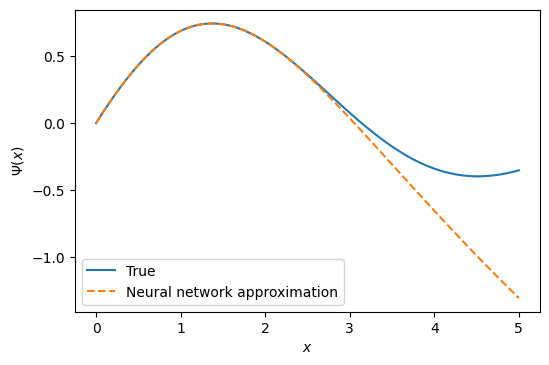

In [11]:
# Optimize (same algorithm as in Lagaris)
optimizer = torch.optim.LBFGS(N.parameters())

# The collocation points used by Lagaris
x = torch.Tensor(np.linspace(0, 2, 100)[:, None])

# Run the optimizer
def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l
    
for i in range(10):
    optimizer.step(closure)

# Let's compare the result to the true solution
xx = np.linspace(0, 5, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots(dpi=100)
ax.plot(xx, yt, label='True')
ax.plot(xx, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(loc='best');

# Try 1 ODE with my code

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

In [5]:
# data range
x = torch.Tensor(np.linspace(0, 2, 100)[:, None])

learning_rate = 0.001
n_epoch = 5000

In [6]:
# full connected network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [7]:
# N is a Neural Network - has 1 hidden layer
N = NeuralNet(1, 50, 1).to(device)

# Initial condition
A = 0.

# The Psi_t function
Psi_t = lambda x: A + x * N(x)

# The right hand side function
f = lambda x, Psi: torch.exp(-x / 5.0) * torch.cos(x) - Psi / 5.0

In [8]:
# The loss function
def loss_ode(x):
    x.requires_grad = True

    outputs = N(x)

    
    der = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                                  create_graph=True)[0]

    l1 = torch.sum((der - f(x, outputs))**2)

    ic = torch.sum((outputs[0] - A)**2)
    return l1+ic

In [9]:
# Optimize
optimizer = torch.optim.Adam(N.parameters(), lr=learning_rate) 

# traning loop
for epoch in range(n_epoch):
    # forward
    l = loss_ode(x)

    # backward
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'epoch {epoch+1}, loss = {l.item():.4f}')

epoch 10, loss = 9.5367
epoch 20, loss = 6.0445
epoch 30, loss = 4.2483
epoch 40, loss = 2.8960
epoch 50, loss = 2.0712
epoch 60, loss = 1.5501
epoch 70, loss = 1.2241
epoch 80, loss = 1.0657
epoch 90, loss = 1.0174
epoch 100, loss = 1.0074
epoch 110, loss = 0.9859
epoch 120, loss = 0.9556
epoch 130, loss = 0.9182
epoch 140, loss = 0.8901
epoch 150, loss = 0.8498
epoch 160, loss = 0.8089
epoch 170, loss = 0.7819
epoch 180, loss = 0.7579
epoch 190, loss = 0.7327
epoch 200, loss = 0.6701
epoch 210, loss = 0.6784
epoch 220, loss = 0.6320
epoch 230, loss = 0.6145
epoch 240, loss = 0.6134
epoch 250, loss = 0.5685
epoch 260, loss = 0.5669
epoch 270, loss = 0.5570
epoch 280, loss = 0.5464
epoch 290, loss = 0.5411
epoch 300, loss = 0.5912
epoch 310, loss = 0.6011
epoch 320, loss = 0.5899
epoch 330, loss = 0.5891
epoch 340, loss = 0.5696
epoch 350, loss = 0.5705
epoch 360, loss = 0.5608
epoch 370, loss = 0.5596
epoch 380, loss = 0.5308
epoch 390, loss = 0.5333
epoch 400, loss = 0.5086
epoch 410

KeyboardInterrupt: 

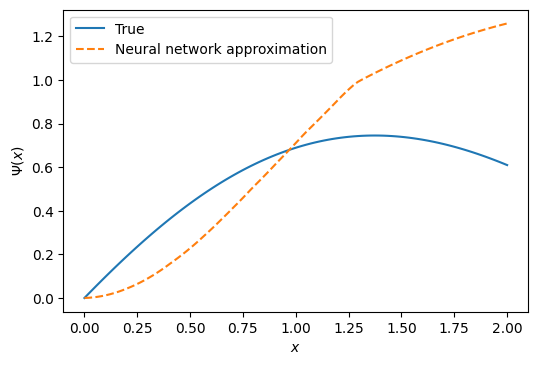

In [ ]:
# Let's compare the result to the true solution
xx = np.linspace(0, 2, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots(dpi=100)
ax.plot(xx, yt, label='True')
ax.plot(xx, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(loc='best');